In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import os
from tqdm import tqdm

from cell_inference.config import paths, params
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.random_parameter_generator import generate_predicted_parameters_from_config
from cell_inference.utils.transform.geometry_transformation import unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp, scaled_stats_indices, GRID_SHAPE
import cell_inference.utils.feature_extractors.SummaryStats2D as ss2
from cell_inference.utils.metrics.corrcoef import corrcoef

%matplotlib inline

simulate_prediction = True

if simulate_prediction:
    h.load_file('stdrun.hoc')
    h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)
    h.tstop = params.TSTOP
    h.dt = params.DT
    h.steps_per_ms = 1/h.dt
    geo_standard = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')

## Load data

#### In vivo data

In [2]:
invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikeWaveforms_NP_SUTempFilter_NPExample'
# invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikes_NPUnits_large.h5'

INVIVO_PATH = 'cell_inference/resources/invivo'
INVIVO_DATA_PATH = os.path.join(INVIVO_PATH, invivo_name + '.h5')
INVIVO_LFP_PATH = os.path.join(INVIVO_PATH, 'lfp_' + invivo_name + '.npz')  # LFP and labels
INVIVO_STATS_PATH = os.path.join(INVIVO_PATH, 'summ_stats_' + invivo_name + '.npz')  # summary statistics

with h5py.File(INVIVO_DATA_PATH,'r') as hf:
    IDs = hf['ID'][()][np.load(INVIVO_LFP_PATH)['good_indices']]

invivo_stats = np.load(INVIVO_STATS_PATH)['x']
layer = np.load(INVIVO_STATS_PATH)['layer']
y_c = np.load(INVIVO_STATS_PATH)['yc']

layer_idx = {L: np.nonzero(layer==L)[0] for L in np.unique(layer)}
sort_idx = np.argsort(np.array([idx.size for idx in layer_idx.values()]))
layer_idx = dict(zip(np.asarray(list(layer_idx.keys()))[sort_idx], np.asarray(list(layer_idx.values()), dtype=object)[sort_idx]))
layer_clr = ['c', 'r', 'y']
layer_names = list(layer_idx.keys())

#### Simulation data

In [3]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Reduced_Order_trunkLR4_Loc5_restrict_h') # select trial

STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics
STATS = np.load(STATS_PATH)
sim_stats = STATS['x']
n_sim_stats = sim_stats.shape[1]

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'h', 'phi', 'l_t', 'r_t']


### Transform labels

#### Orientation

In [4]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
#     orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
#     orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [5]:
has_yshift = 'y' in label_list
if has_yshift:
    ys_idx = label_list.index('y')
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'
    ranges['ys'] = [-150, 150] # set bound for normalization

#### Normalization

In [6]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

### Get magnitude distribution

In [7]:
scaled_idx = scaled_stats_indices()
max_mag_idx = [33, 38]
max_mag = np.amax(sim_stats[:, max_mag_idx], axis=1)
max_mag_invivo = np.amax(invivo_stats[:, max_mag_idx], axis=1)
mag_scale = np.mean(max_mag) / np.mean(max_mag_invivo)
invivo_stats_scaled = invivo_stats.copy()
invivo_stats_scaled[:, scaled_idx] *= mag_scale
print(mag_scale)

0.07441546772591663


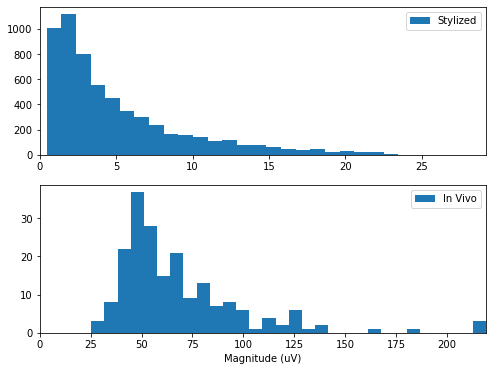

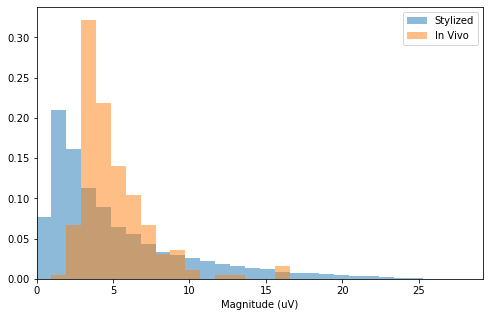

In [8]:
nbins = 30

plt.figure(figsize=(8, 6))
plt.subplot(211)
_, bins, _ = plt.hist(max_mag, bins=nbins, label='Stylized')
plt.xlim([0,bins[-1]])
plt.legend()
plt.subplot(212)
_, bins, _ = plt.hist(max_mag_invivo, bins=nbins, label='In Vivo')
plt.xlim([0,bins[-1]])
plt.legend()
plt.xlabel('Magnitude (uV)')

bins = np.linspace(0, max(np.amax(max_mag), np.amax(mag_scale * max_mag_invivo)), nbins + 1)
plt.figure(figsize=(8, 5))
plt.hist(max_mag, bins=bins, label='Stylized', density=True, alpha=0.5)
plt.hist(mag_scale * max_mag_invivo, bins=bins, label='In Vivo', density=True, alpha=0.5)
plt.xlim([0, bins[-1]])
plt.legend()
plt.xlabel('Magnitude (uV)')
plt.show()

## Load model

In [9]:
import torch

model_name = 'CNN_batch256' # select model
isCNN = 'CNN' in model_name

if direction_vec:
    model_name += '_dv'
MODEL_PATH = os.path.join(TRIAL_PATH, model_name)
PARAM_PATH = os.path.join(MODEL_PATH, model_name + '.pth')
PRED_PATH = os.path.join(MODEL_PATH, model_name + '_prediction.csv')

if isCNN:
    from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork, ActivationTypes
    num_filters = [8, 16, 16, 32, 32, 64, 64, 64, 32, 8]
    model = ConvolutionalNetwork(in_channels=2, out_features=len(label_list), num_filters=num_filters)
else:
    from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
    model = FullyConnectedNetwork(in_features=n_sim_stats, out_features=len(label_list))

device = torch.device('cpu')
model.load_state_dict(torch.load(PARAM_PATH, map_location=device))
model.to(device)
model.eval()

ConvolutionalNetwork(
  (conv3d_block): Sequential(
    (conv0): Conv3d(2, 8, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), padding_mode=replicate)
    (actv0): ReLU()
    (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 0, 0), padding_mode=replicate)
    (actv1): ReLU()
    (conv2): Conv3d(16, 16, kernel_size=(3, 2, 3), stride=(2, 1, 1), padding_mode=replicate)
    (actv2): ReLU()
  )
  (conv2d_block): Sequential(
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (actv3): ReLU()
    (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (actv4): ReLU()
    (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (actv5): ReLU()
    (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding_mode=replicate)
    (actv6): ReLU()
    (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (actv7): ReLU()
  )
  (conv1x1_block): Sequential(
    (conv8): Conv2d(64, 32

#### Data for CNN

In [10]:
if isCNN:
    from cell_inference.utils.transform.data_transform import log_modulus
    
    n_fold = 30
    max_logmod = np.ceil(np.log2(n_fold))  # max value after transform
    n_fold = 2**max_logmod - 1
    
    invivo_lfp_scaled = 1000 * mag_scale * np.load(INVIVO_LFP_PATH)['x']  # mV -> uV, then scale invivo lfp
    lfp_trans = np.empty_like(invivo_lfp_scaled)
    for i in range(invivo_lfp_scaled.shape[0]):
        ref_mag = np.amax(np.abs(invivo_lfp_scaled[i])) / n_fold
        lfp_trans[i] = log_modulus(invivo_lfp_scaled[i], ref_mag)
    
    lfp_trans = np.stack((invivo_lfp_scaled, lfp_trans), axis=1)
    lfp_trans = lfp_trans.reshape(lfp_trans.shape[:3] + (GRID_SHAPE[0], -1))

### Predict on in vivo data

In [11]:
if isCNN:
    pred = model(torch.Tensor(lfp_trans).to(device)).to("cpu").detach().numpy()
else:
    pred = model(torch.Tensor(invivo_stats_scaled).to(device)).to("cpu").detach().numpy()

for i, lb in enumerate(label_list):
    pred[:, i] = org_scale(pred[:, i], ranges[lb])
pred_list = label_list.copy()
pred_list = label_list.copy()
if has_yshift:
    pred[:, ys_idx] = y_c - pred[:, ys_idx]
    pred_list[pred_list.index('ys')] = 'y'
if direction_vec:
    pred[:, orient_idx1] = trivarnorm2unitsphere(pred[:, orient_idx1])
    pred = np.hstack([pred, unitsphere2hphi(pred[:, orient_idx1])[:, [1]]])
    pred_list[pred_list.index('vy')] = 'h'
    pred_list.append('phi')
pred_dict = dict(zip(pred_list, pred.T))
pred_dict['layer'] = layer

In [12]:
df_pred = pd.DataFrame(pred_dict, index=IDs)
df_pred.to_csv(PRED_PATH, index_label='cell id') # save to csv

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_pred.sort_values(by='y'))

,y,d,theta,l_t,r_t,vx,h,vz,phi,layer
399,-899.645935,143.535431,0.139051,-128.987305,0.903441,0.519053,0.823124,0.230329,1.153154,Layer6
404,-879.990967,243.679779,0.046804,617.324219,0.539841,-0.639871,0.767956,-0.028431,-1.615200,Layer6
396,-875.374634,155.801254,0.153489,1274.628296,0.513559,-0.116192,0.944994,0.305755,-0.363163,Layer6
395,-875.103210,185.165680,0.335513,361.942322,0.766702,-0.383913,0.923203,-0.017534,-1.616436,Layer6
494,-873.806030,143.077637,0.398500,380.656128,0.774906,-0.094055,0.991538,0.089475,-0.810347,Layer6
85,-871.966492,208.022766,0.244141,866.410706,0.565596,-0.566043,0.815801,0.118591,-1.364274,Layer6
457,-868.651794,101.780403,0.238399,893.181396,0.651252,-0.405864,0.827583,0.387790,-0.808168,Layer6
68,-868.190430,114.493881,0.335621,971.551147,0.674526,-0.419978,0.872641,0.249232,-1.035214,Layer6
89,-863.913086,153.359985,0.566588,586.467041,0.644865,-0.487268,0.870860,0.064600,-1.438989,Layer6
398,-862.928406,140.855164,0.064793,945.521667,0.634009,-0.351084,0.934570,0.057613,-1.408146,Layer6


Average direction vector (vx, vy, vz) = (-0.302, 0.938, 0.168)


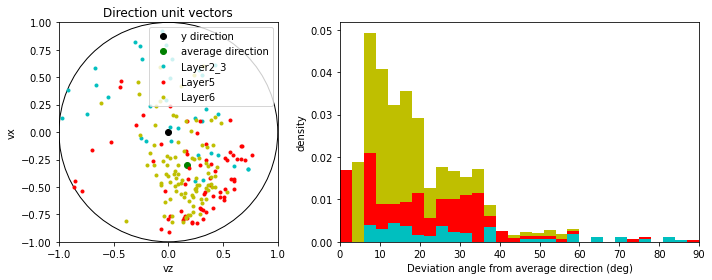

In [13]:
bins = 30
avg_direct = trivarnorm2unitsphere(np.mean(pred[:, orient_idx1], axis=0))
deviation_ang = np.arccos(pred[:, orient_idx1] @ avg_direct.T)
weights = 1 / np.sin(np.fmax(deviation_ang, np.pi / bins / 8))
deviation_ang *= 180 / np.pi

print('Average direction vector (vx, vy, vz) = (%.3f, %.3f, %.3f)' % tuple(avg_direct))

plt.figure(figsize=(10, 4))

plt.subplot(1, 5, (1, 2))
plt.gca().add_artist(plt.Circle((0., 0.), 1.0, edgecolor='k', fill=False))
plt.plot(0., 0., 'ko', label='y direction')
plt.plot(*avg_direct[[2, 0]], 'go', label='average direction')
for i, (L, idx) in enumerate(layer_idx.items()):
    plt.plot(pred_dict['vz'][idx], pred_dict['vx'][idx],
             marker='.', linestyle='None', color=layer_clr[i], label=L)
plt.xlabel('vz')
plt.ylabel('vx')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.legend()
plt.title('Direction unit vectors')

plt.subplot(1, 5, (3, 5))
plt.hist([deviation_ang[idx] for idx in layer_idx.values()], bins=bins, range=(0, 90), density=True,
         weights=[weights[idx] for idx in layer_idx.values()], label=layer_names, color=layer_clr, stacked=True)
plt.xlim([0, 90])
plt.xlabel('Deviation angle from average direction (deg)')
plt.ylabel('density')

plt.tight_layout()
plt.show()

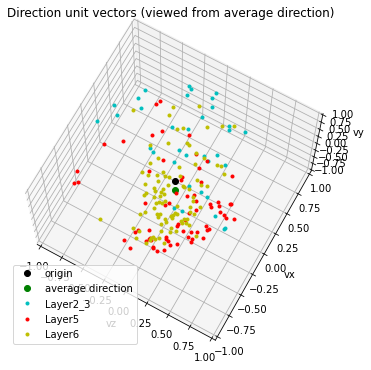

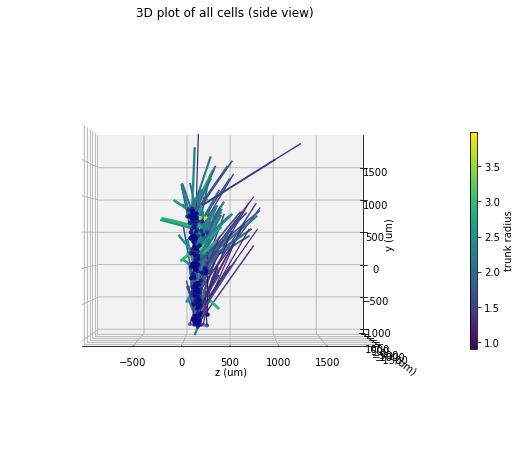

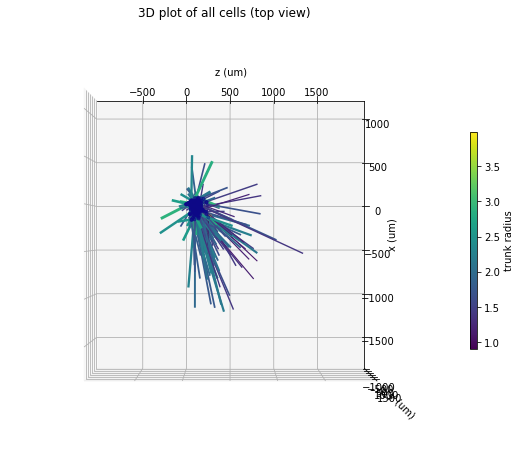

In [14]:
from cell_inference.utils.plotting.plot_all_cells import plot_all_cells
%matplotlib inline
# %matplotlib notebook

elev = 180 / np.pi * np.arcsin(avg_direct[1])
azim = 180 / np.pi * np.arctan2(*avg_direct[[0, 2]])

ax = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
ax.plot3D(0, 0, 0, 'ko', label='origin')
ax.plot3D(*avg_direct[[2, 0, 1]], 'go', label='average direction')
for i, (L, idx) in enumerate(layer_idx.items()):
    ax.plot3D(pred_dict['vz'][idx], pred_dict['vx'][idx], pred_dict['h'][idx],
              marker='.', linestyle='None', color=layer_clr[i], label=L)
ax.set_xlabel('vz')
ax.set_ylabel('vx')
ax.set_zlabel('vy')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(elev=elev, azim=azim)
ax.legend()
ax.set_title('Direction unit vectors (viewed from average direction)')

fig, ax = plot_all_cells(df_pred, figsize=(10, 8), view='2D')
ax.set_title('3D plot of all cells (side view)')
fig, ax = plot_all_cells(df_pred, figsize=(10, 8), view=(90, -90))
ax.set_title('3D plot of all cells (top view)')

plt.show()

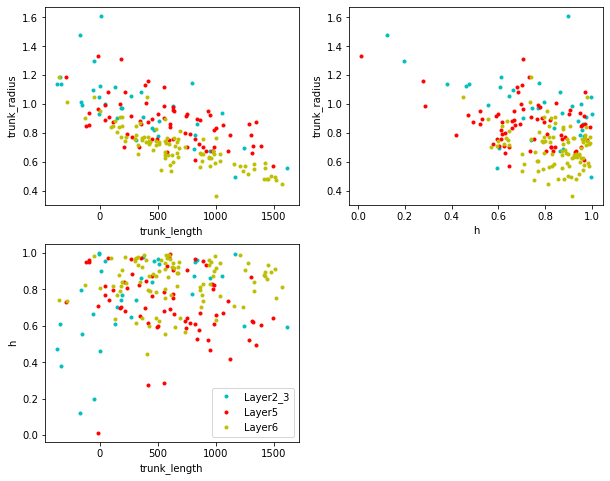

In [15]:
%matplotlib inline

plt.figure(figsize=(10, 8))
for i, (L, idx) in enumerate(layer_idx.items()):
    plt.subplot(221)
    plt.plot(pred_dict['l_t'][idx], pred_dict['r_t'][idx],
             marker='.', linestyle='None', color=layer_clr[i], label=L)
    plt.subplot(222)
    plt.plot(pred_dict['h'][idx], pred_dict['r_t'][idx],
             marker='.', linestyle='None', color=layer_clr[i], label=L)
    plt.subplot(223)
    plt.plot(pred_dict['l_t'][idx], pred_dict['h'][idx],
             marker='.', linestyle='None', color=layer_clr[i], label=L)
plt.subplot(221)
plt.xlabel('trunk_length')
plt.ylabel('trunk_radius')
plt.subplot(222)
plt.xlabel('h')
plt.ylabel('trunk_radius')
plt.subplot(223)
plt.xlabel('trunk_length')
plt.ylabel('h')
plt.legend()
plt.show()

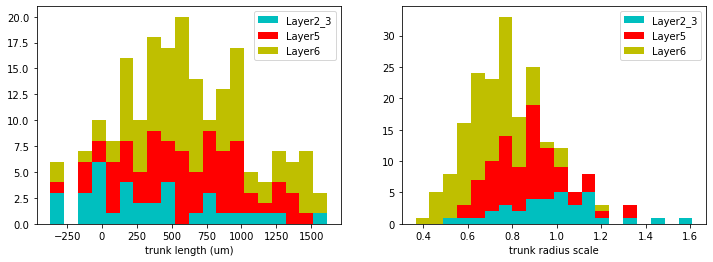

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist([pred_dict['l_t'][idx] for idx in layer_idx.values()], bins=20, label=layer_names, color=layer_clr, stacked=True)
plt.xlabel('trunk length (um)')
plt.legend()
plt.subplot(122)
plt.hist([pred_dict['r_t'][idx] for idx in layer_idx.values()], bins=20, label=layer_names, color=layer_clr, stacked=True)
plt.xlabel('trunk radius scale')
plt.legend()
plt.show()

## Simulate with predicted parameters

#### Whether run simulation

In [17]:
if simulate_prediction:
    if config_dict['Simulation_Parameters']['gmax_mapping'] is None:
        gmax = config_dict['Simulation_Parameters']['gmax']
    else:
        pass # TODO
    stim_param = config_dict['Simulation_Parameters']['stim_param']

    # Biophysical parameters
    filepath = config_dict['Simulation_Parameters']['full_biophys']
    with open(filepath) as f:
        full_biophys = json.load(f)

    # common parameters
    biophys_param = config_dict['Simulation_Parameters']['biophys_param']
    biophys_comm = config_dict['Simulation_Parameters']['biophys_comm']

    # whether use parameter interpreter
    interpret_params = config_dict['Simulation_Parameters']['interpret_params'] if 'interpret_params' in config_dict['Simulation_Parameters'].keys() else False

    number_locs = 1
    labels, rand_param, loc_param, geo_param = generate_predicted_parameters_from_config(config_dict, pred_dict, number_locs=number_locs)
    number_cells = geo_param.shape[0]
    number_samples = labels.shape[0]

    print(loc_param.shape)
    print(geo_param.shape)
    print(labels.shape)

(198, 1, 6)
(198, 2)
(198, 7)


### Create simulation and run

In [18]:
import time
import datetime

if simulate_prediction:
    timer_start = time.time()

    sim = Simulation(
        cell_type = CellTypes.REDUCED_ORDER,
        ncell = number_cells,
        geometry = geo_standard,
        electrodes = params.ELECTRODE_POSITION,
        loc_param = loc_param,
        geo_param = geo_param,
        biophys = biophys_param,
        full_biophys = full_biophys,
        biophys_comm = biophys_comm,
        gmax = gmax,
        stim_param = stim_param,
        interpret_params = interpret_params,
        min_distance = params.MIN_DISTANCE,
        record_soma_v = False,
        spike_threshold = params.SPIKE_THRESHOLD
    )

    sim.run_neuron_sim()

    print('Simulation run time: ' + str(datetime.timedelta(seconds=time.time() - timer_start)))

Simulation run time: 0:00:31.201235


### Get LFPs
#### Save what

In [19]:
save_lfp = True
save_stats = True

#### Remove cells with invalid firing pattern

In [20]:
if simulate_prediction:
    nspk, _ = sim.get_spike_number('all')

    valid = nspk==1
    invalid = np.nonzero(~valid)[0]
    invalid_nspk = nspk[invalid]
    for n in np.unique(invalid_nspk):
        print('%d cells fire %d times.' % (np.count_nonzero(invalid_nspk==n), n))

    invalid_params = {}
    invalid_params['geo_param'] = geo_param[invalid, :]
    invalid_params['gmax'] = sim.gmax[invalid]

    invalid_samples = (number_locs * invalid.reshape(-1,1) + np.arange(number_locs)).ravel()
    number_samples -= invalid_samples.size
    labels = np.delete(labels, invalid_samples, axis=0)
    rand_param = np.delete(rand_param, invalid_samples, axis=0)
    gmax = np.repeat(sim.gmax[valid], number_locs)

#### Reshape LFP array. Filter each channel. Get window of spike for each sample.

In [21]:
if simulate_prediction:
    timer_start = time.time()

    lfp = sim.get_lfp('all', multiple_position=True)[valid]  # (cells x locs x channels x time)

    print('LFP run time: ' + str(datetime.timedelta(seconds=time.time() - timer_start)))

    lfp = lfp.reshape((-1,)+lfp.shape[-2:]).transpose((0,2,1))  # -> (samples x channels x time) -> (samples x time x channels)

    start_idx = int(max(np.ceil(stim_param['start']/h.dt) - params.PK_TR_IDX_IN_WINDOW, 0)) # ignore signal before
    pad_spike_window = False
    bad_cases = tuple(range(-1,3)) if pad_spike_window else tuple(range(3))
    if 'y' in inference_list:
        y_idx = inference_list.index('y')
        ycoord = lambda i: labels[i, y_idx]
    else:
        ycoord = lambda i: None

    bad_indices = {bad: [] for bad in bad_cases}
    lfp_list = []
    yshift = []
    summ_stats = []
    good_count = 0

    for i in tqdm(range(number_samples)):
        bad, g_lfp, _, _, _, ys, ss = process_lfp(
            lfp[i,start_idx:,:], dt=None, ycoord=ycoord(i), gauss_filt=True,
            calc_summ_stats=save_stats, additional_stats=3, err_msg=True
        )
        bad_indices[bad].append(i)
        if bad<=0:
            good_count += 1
            lfp_list.append(g_lfp)
            yshift.append(ys)
            if save_stats:
                summ_stats.append(ss)

    t = sim.t()[:params.WINDOW_SIZE]
    windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)
    yshift = np.array(yshift)
    summ_stats = np.array(summ_stats)

    bad_idx = np.array([i for bad, indices in bad_indices.items() if bad>0 for i in indices])
    good_indices = np.sort([i for bad, indices in bad_indices.items() if bad<=0 for i in indices])
    print('%d good samples out of %d samples.' % (good_count, number_samples))
    for bad, indices in bad_indices.items():
        print('Bad case %d bad: %d samples.' % (bad, len(indices)))

LFP run time: 0:00:04.402186


100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:06<00:00, 28.37it/s]

198 good samples out of 198 samples.
Bad case 0 bad: 198 samples.
Bad case 1 bad: 0 samples.
Bad case 2 bad: 0 samples.


### Save configurations and simulation data

In [22]:
PRED_LFP_PATH = os.path.join(MODEL_PATH, 'lfp_' + model_name + '_pred.npz')  # LFP and labels
PRED_STATS_PATH = os.path.join(MODEL_PATH, 'summ_stats_' + model_name + '_pred.npz')  # summary statistics

In [23]:
if simulate_prediction:
    if save_lfp:
        np.savez(PRED_LFP_PATH, t=t, x=windowed_lfp, y=labels, ys=yshift, rand_param=rand_param, gmax=gmax,
                 bad_indices=bad_indices, good_indices=good_indices, invalid_params=invalid_params,
                 valid=valid, invalid=invalid)
    if save_stats:
        np.savez(PRED_STATS_PATH, x=summ_stats, y=labels[good_indices], ys=yshift,
                 rand_param=rand_param[good_indices], gmax=gmax[good_indices])

## Evaluate prediction

In [24]:
valid = np.load(PRED_LFP_PATH)['valid']
invalid = np.load(PRED_LFP_PATH)['invalid']
pred_lfp = np.load(PRED_LFP_PATH)['x'][valid]

good_indices = np.load(INVIVO_LFP_PATH)['good_indices']
with h5py.File(INVIVO_DATA_PATH,'r') as hf:
    ids = hf['ID'][()][good_indices[valid]]
invivo_lfp = np.load(INVIVO_LFP_PATH)['x'][good_indices[valid]]
t = np.load(INVIVO_LFP_PATH)['t']

print('%d invalid IDs: ' % (len(invalid)))
print(IDs[good_indices[invalid]])

0 invalid IDs: 
[]


#### Calculate correlation coefficient

In [25]:
corr = []
for i in range(pred_lfp.shape[0]):
    corr.append(corrcoef(invivo_lfp[i], pred_lfp[i]))
corr = np.array(corr)

df_corr = pd.DataFrame({'Corr': corr, 'layer': layer[valid]}, index=ids).sort_values('Corr')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_corr)

,Corr,layer
313,-0.688516,Layer2_3
270,-0.637997,Layer5
534,-0.611066,Layer2_3
288,-0.580162,Layer5
277,-0.568330,Layer5
347,-0.547565,Layer2_3
346,-0.496979,Layer2_3
274,-0.424788,Layer5
169,-0.421242,Layer6
110,-0.406137,Layer6


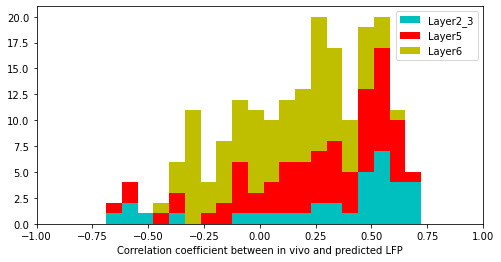

In [26]:
plt.figure(figsize=(8, 4))
plt.hist([corr[idx][valid[idx]] for idx in layer_idx.values()], bins=20, label=layer_names, color=layer_clr, stacked=True)
plt.xlabel('Correlation coefficient between in vivo and predicted LFP')
plt.xlim([-1, 1])
plt.legend()
plt.show()

#### Check LFP

In [27]:
select_ID = 227 #531 #78
select_id = np.nonzero(ids==select_ID)[0][0]
select_stats = invivo_stats[valid][select_id]

display(df_pred.loc[[select_ID]])

,y,d,theta,l_t,r_t,vx,h,vz,phi,layer
227,186.268402,165.097351,-0.991416,1300.525879,0.785076,-0.472351,0.868946,0.147709,-1.267719,Layer5


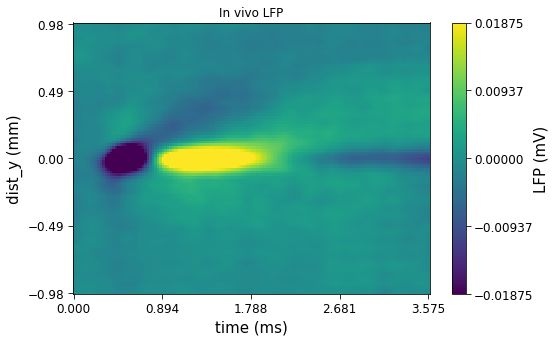

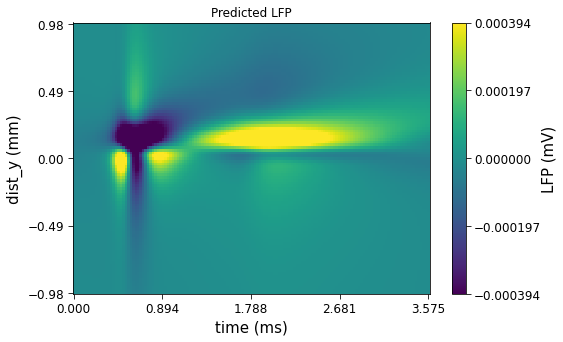

In [28]:
max_mag_idx_x = np.asarray(max_mag_idx) - 2  # max magnitue x idx
ix = int(select_stats[max_mag_idx_x][np.argmax(select_stats[max_mag_idx])])
fontsize = 15
labelpad = 0
ticksize = 12
tick_length = 5
nbins = 5

grid_shape = (ss2.GRID_SHAPE[0], ss2.NY)
elec_d = ss2.REL_IDX * ss2.DY
lfp_invivo = invivo_lfp[select_id].reshape((-1,) + grid_shape)[:, ix, :]
lfp_pred = pred_lfp[select_id].reshape((-1,) + grid_shape)[:, ix, :]

plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_d, lfp=lfp_invivo,
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', axes=plt.gca())
plt.title('In vivo LFP')
plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_d, lfp=lfp_pred,
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', axes=plt.gca())
plt.title('Predicted LFP')
plt.show()

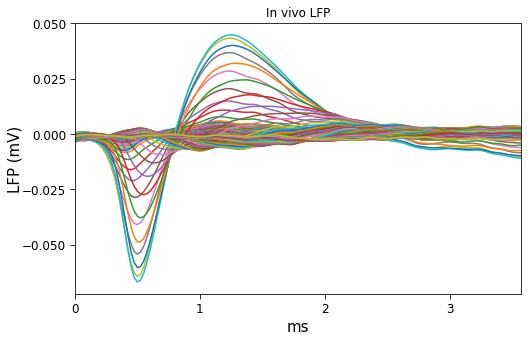

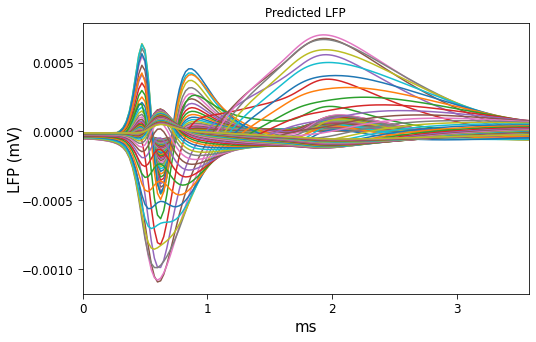

In [29]:
plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, lfp_invivo, # electrodes=elec_d,
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.title('In vivo LFP')
plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, lfp_pred, # electrodes=elec_d,
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.title('Predicted LFP')
plt.show()